In [1]:
suppressMessages(library(Seurat, quietly = TRUE))
suppressMessages(library(ggplot2, quietly = TRUE))
suppressMessages(library(dplyr, quietly = TRUE))

## Read gene and protein epxression data

In [2]:
# read RNA data
cbmc.rna <- as.sparse(read.csv(file = "./data/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv", header = TRUE, row.names = 1))
cbmc.rna <- CollapseSpeciesExpressionMatrix(cbmc.rna)

# read protein data
cbmc.adt <- as.sparse(read.csv(file = "./data/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv", header = TRUE, row.names = 1))
# remove CCR5, CC7, and CD10 duo to low quality
cbmc.adt <- cbmc.adt[setdiff(rownames(cbmc.adt), c("CCR5", "CCR7", "CD10")), ] 

In [3]:
dim(cbmc.rna)

[1] 20501  8617

In [4]:
dim(cbmc.adt)

[1]   10 8617

In [5]:
rownames(cbmc.adt)

[1] "CD3"    "CD4"    "CD8"    "CD45RA" "CD56"   "CD16"   "CD11c"  "CD14"  
 [9] "CD19"   "CD34"

## Preprocessing scRNA data

In [6]:
# Create a Seurat object that serves as a container for both data and analyses
cbmc <- CreateSeuratObject(counts = cbmc.rna)

# QC based on number of unique genes and percentage of reads mapped to the mitochondrial genome
# cbmc[["percent.mt"]] <- PercentageFeatureSet(cbmc, pattern = "^MT-")
# cbmc <- subset(cbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# normalize data for each cell by total expression
cbmc <- NormalizeData(cbmc)

# identify highly variable features
cbmc <- FindVariableFeatures(cbmc)

# scale data so that the mean is 0 and variance is 1 for each gene
cbmc <- ScaleData(cbmc)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Centering and scaling data matrix


## PCA on RNA expression data

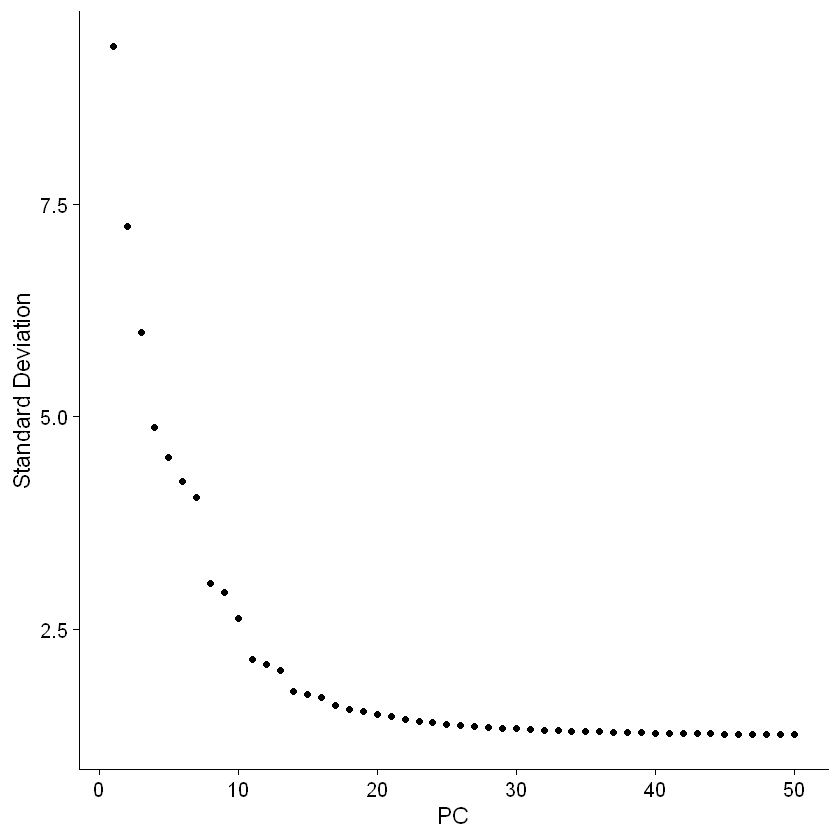

In [7]:
# PCA 
cbmc <- RunPCA(cbmc, verbose = FALSE)
ElbowPlot(cbmc, ndims = 50)

## Cell clustering based on RNA expression and PCA

In [8]:
# Construct a KNN graph
cbmc <- FindNeighbors(cbmc, dims = 1:25)

# group cells together
cbmc <- FindClusters(cbmc, resolution = 0.8)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8617
Number of edges: 347548

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8592
Number of communities: 19
Elapsed time: 0 seconds


## Run non-linear dimensional reduction for visualization 

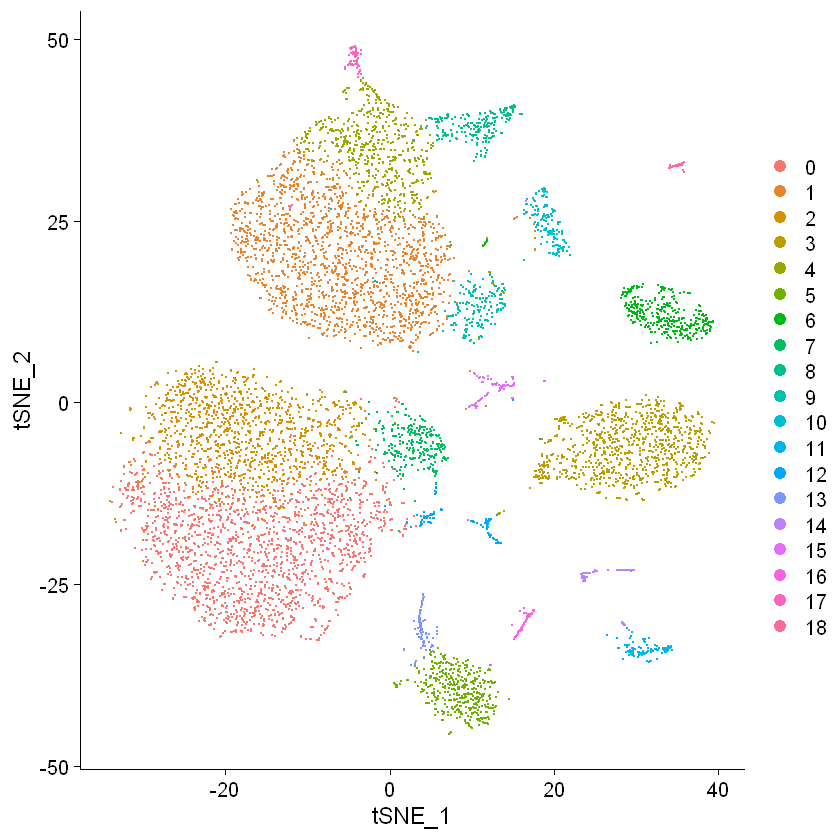

In [9]:
cbmc <- RunTSNE(cbmc, dims = 1:25, method = "FIt-SNE")
DimPlot(cbmc)

## Assigning cell type to clusters

In [10]:
# identify markers for each cluster
cbmc.rna.markers <- suppressMessages(
    FindAllMarkers(cbmc, max.cells.per.ident = 100, min.diff.pct = 0.3, only.pos = TRUE))
cbmc.rna.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
4.280959e-21,1.1368139,0.872,0.274,8.776395e-17,0,IL7R
3.149773e-20,1.0246049,0.985,0.525,6.457351e-16,0,LTB
8.557593e-20,0.9786093,0.964,0.527,1.754392e-15,0,LDHB
9.951232e-18,0.9599525,0.896,0.327,2.040102e-13,0,IL32
5.600013e-16,0.9921405,0.793,0.255,1.148059e-11,0,TRAC
2.149358e-32,2.9808995,1.000,0.461,4.406398e-28,1,S100A8
8.816391e-32,2.7975239,0.999,0.537,1.807448e-27,1,S100A9
2.420747e-30,2.6626600,0.940,0.181,4.962774e-26,1,S100A12
1.244347e-27,2.1318881,1.000,0.464,2.551035e-23,1,LYZ
1.045525e-18,2.0994791,0.818,0.203,2.143432e-14,1,RP11-1143G9.4


Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

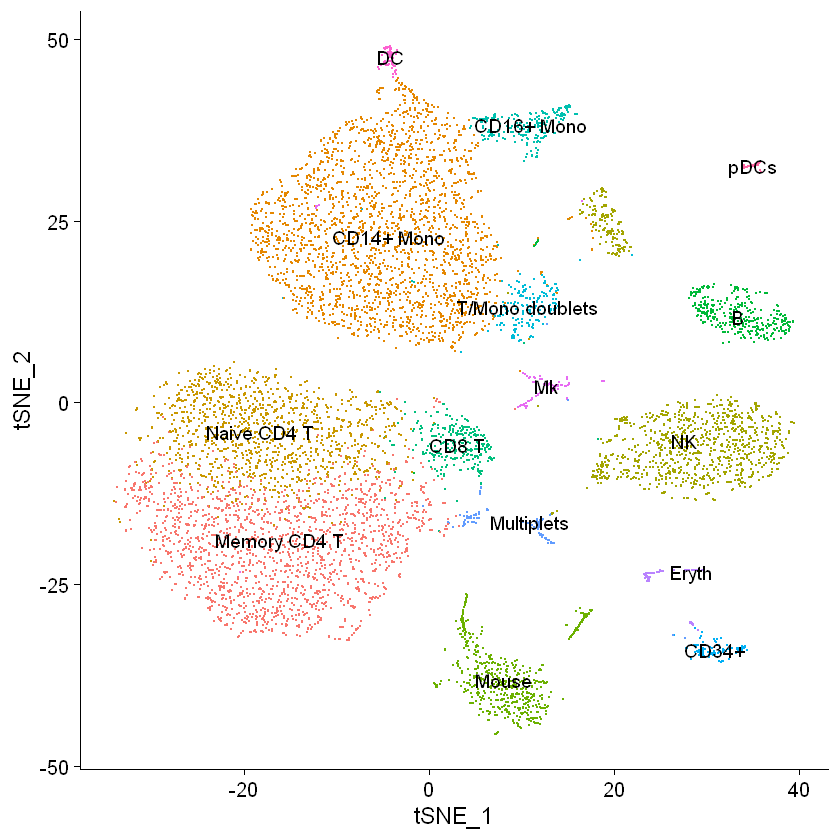

In [11]:
# rename clusters with cell type
new.cluster.ids <- c("Memory CD4 T", "CD14+ Mono", "Naive CD4 T", "NK", "CD14+ Mono", "Mouse", "B", 
                     "CD8 T", "CD16+ Mono", "T/Mono doublets", "NK", "CD34+", "Multiplets", "Mouse", "Eryth", "Mk", 
                     "Mouse", "DC", "pDCs")

names(new.cluster.ids) <- levels(cbmc)
cbmc <- suppressMessages(RenameIdents(cbmc, new.cluster.ids))
DimPlot(cbmc, label = TRUE) + NoLegend()

## Preprocessing protein expression data

In [12]:
cbmc[["ADT"]] <- CreateAssayObject(counts = cbmc.adt)

# normalization using the CLR method
cbmc <- NormalizeData(cbmc, assay = "ADT", normalization.method = "CLR")
cbmc <- ScaleData(cbmc, assay = "ADT")

Normalizing across features
Centering and scaling data matrix


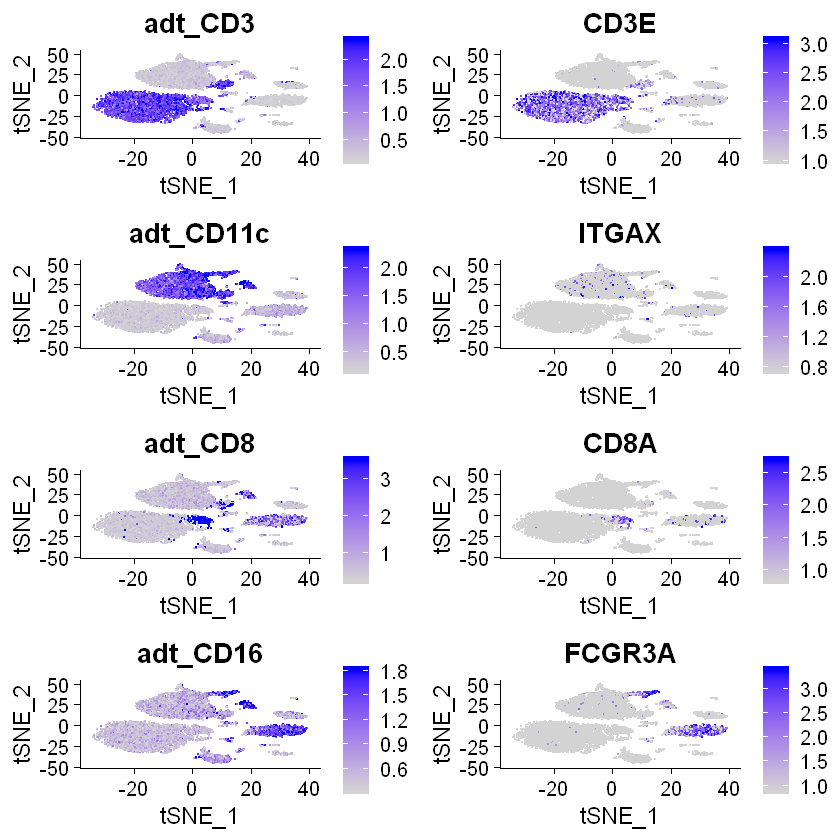

In [13]:
# visualize protein expression on RNA clusters
FeaturePlot(cbmc, features = c("adt_CD3", "CD3E", "adt_CD11c", "ITGAX", "adt_CD8", "CD8A", "adt_CD16",
                               "FCGR3A"), min.cutoff = "q05", max.cutoff = "q95", ncol = 2)

## Identify differentially expressed proteins between clusters

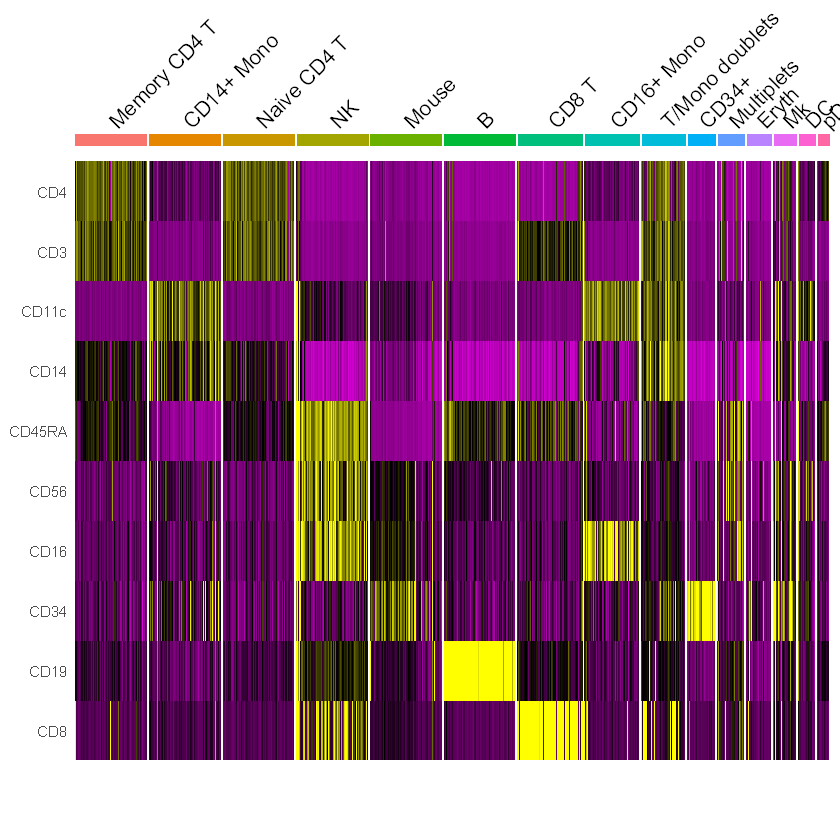

In [14]:
# downsampling
cbmc.small <- subset(cbmc, downsample = 300)
DefaultAssay(cbmc.small) <- "ADT"

suppressMessages(adt.markers <- FindAllMarkers(cbmc.small, only.pos = TRUE))
DoHeatmap(cbmc.small, features=unique(adt.markers$gene), size=4.5) + NoLegend()

In [15]:
# remove Multiplets and Mouse cells
cbmc <- subset(cbmc, idents = c("Multiplets", "Mouse"), invert = TRUE)

In [16]:
# export counts of variable genes
variable_genes <- VariableFeatures(cbmc)
write.csv(cbmc[["RNA"]]@counts[variable_genes, ], "./data/rna_counts.csv")

In [17]:
# export scaled counts of variable genes
write.csv(cbmc[["RNA"]]@scale.data, "./data/rna_scaled.csv")

In [18]:
# export scaled protein data
write.csv(cbmc[["ADT"]]@scale.data, "./data/protein_scaled.csv")

In [19]:
# export cluster ids
write.csv(Idents(cbmc), "./data/cell_idents.csv")

## Compare clustering with protein or RNA data

In [20]:
DefaultAssay(cbmc) <- "ADT"

# calculate euclidean distance matrix
adt.data <- GetAssayData(cbmc, slot = "data")
adt.dist <- dist(t(adt.data))

# RNA clustering ids
cbmc[["rnaClusterID"]] <- Idents(cbmc)

# tSNE
cbmc[["tsne_adt"]] <- RunTSNE(adt.dist, assay="ADT", reduction.key="adtTSNE_")

# clustering
cbmc[["adt_snn"]] <- FindNeighbors(adt.dist)$snn
cbmc <- FindClusters(cbmc, resolution=0.2, graph.name="adt_snn")

Building SNN based on a provided distance matrix
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7895
Number of edges: 258146

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9491
Number of communities: 11
Elapsed time: 0 seconds


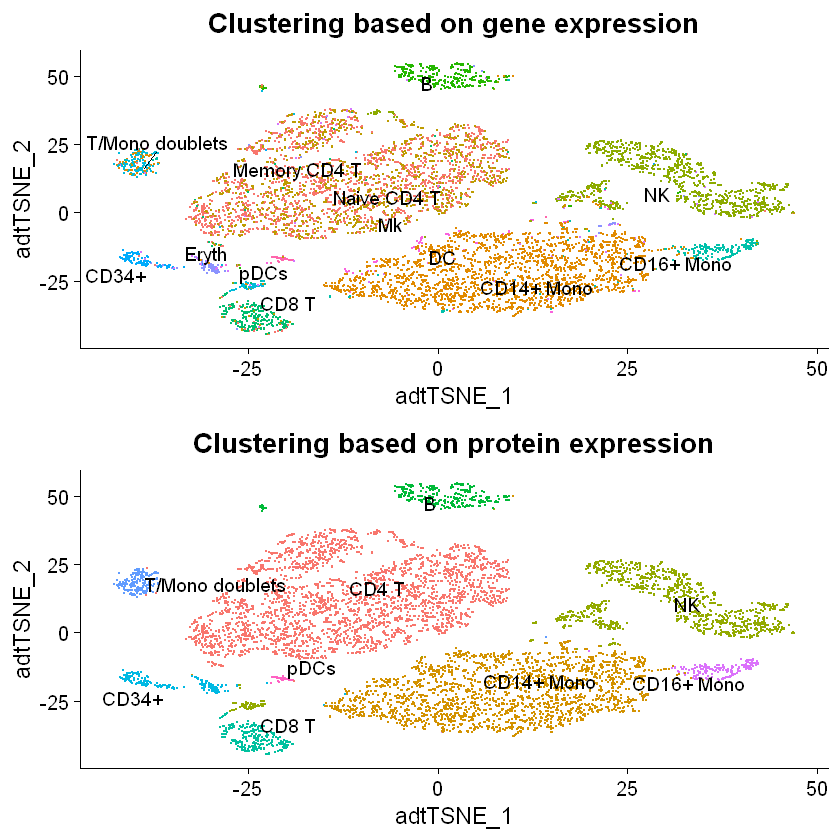

In [21]:
# label clusters
new.cluster.ids <- c("CD4 T", "CD14+ Mono", "NK", "B", "CD8 T", "NK", "CD34+", "T/Mono doublets", 
    "CD16+ Mono", "pDCs", "B")

names(new.cluster.ids) <- levels(cbmc)
cbmc <- RenameIdents(cbmc, new.cluster.ids)

# clustered cell types visualized on the same tsne plot based on protein data
# RNA
tsne_rnaClusters <- (DimPlot(cbmc, reduction="tsne_adt", group.by="rnaClusterID") + NoLegend() +
                     ggtitle("Clustering based on gene expression") + theme(plot.title=element_text(hjust=0.5)))
tsne_rnaClusters <- LabelClusters(plot=tsne_rnaClusters, id="rnaClusterID", size=4)

# protein
tsne_adtClusters <- (DimPlot(cbmc, reduction="tsne_adt") + NoLegend() +
                     ggtitle("Clustering based on protein expression") + theme(plot.title=element_text(hjust=0.5)))
tsne_adtClusters <- LabelClusters(plot=tsne_adtClusters, id="ident", size=4)

CombinePlots(plots=list(tsne_rnaClusters, tsne_adtClusters), ncol=1)